In [3]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import collections
import pickle
import gc

In [7]:
# Read all files
json_files=[]
csv_files=[]
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        fname=os.path.join(dirname, filename)
        if fname.endswith('csv'):
            csv_files.append(fname)
        elif fname.endswith('json'):
            json_files.append(fname)
            
            
# Reorder CSV files
country_codes=list(map(lambda string:''.join(list(filter(lambda word:word.isupper(),string))),csv_files))

country_codes, order=zip(*sorted(list(zip(country_codes,range(len(country_codes)))), key=lambda val:val[0]))
csv_files=[csv_files[ind] for ind in order]

# Reorder json files
country_codes=list(map(lambda string:''.join(list(filter(lambda word:word.isupper(),string))),json_files))
country_codes,order=zip(*sorted(list(zip(country_codes,range(len(country_codes)))), key=lambda val:val[0]))
json_files=[json_files[ind] for ind in order]


def initialize_country_dataframe(dataframe,json_fname,country_code):
    '''First, remove duplicate rows from the dataframe, 
    second, map category_id column to actual categories, 
    third, new column in the dataframe called country_code'''
    
    df=dataframe.copy()
    df.drop_duplicates(inplace=True)
    
    with open(json_fname,'r') as f:
        json_data=json.loads(f.read())

    mapping_dict=dict([(int(dictionary['id']),dictionary['snippet']['title']) for dictionary in json_data['items']])

    df['category']=df['category_id'].replace(mapping_dict)
    del df['category_id']

    df['country_code']=country_code
    
    return df

# Initialize country-by-country dataframe using above written function
dataframes=[]
for ind,code in enumerate(country_codes):
    try:
        df=pd.read_csv(csv_files[ind])
    except:
        df=pd.read_csv(csv_files[ind],engine='python')
                
    df=initialize_country_dataframe(df,json_files[ind],code)
    print(code,df.shape)
    dataframes.append(df)
    
    
# Concatenate individual dataframe to form single main dataframe
dataframe=pd.concat(dataframes)
print(dataframe.shape)


# Remove videos with unknown video id
drop_index=dataframe[dataframe.video_id.isin(['#NAME?','#VALUE!'])].index
dataframe.drop(drop_index, axis=0, inplace=True)

CA (40881, 17)
DE (40840, 17)
FR (40724, 17)
GB (38745, 17)
IN (33089, 17)
JP (14846, 17)
KR (32251, 17)
MX (40402, 17)
RU (40693, 17)
US (40901, 17)
(363372, 17)


In [8]:
# Create feature num_days that indicates the number of days the videos are in trend
video_ids=dataframe.video_id.unique().tolist()
num_days=[]
id_days={}
for vid in tqdm(video_ids):
    days=len(dataframe[dataframe.video_id==vid].trending_date.unique())
    id_days[vid]=days
    num_days.append(days)
    

# Create feature num_countries that indicates the number of countries in the videos trended
video_ids=dataframe.video_id.unique().tolist()
num_countries=[]
id_countries={}
for vid in tqdm(video_ids):
    days=len(dataframe[dataframe.video_id==vid].country_code.unique())
    id_countries[vid]=days
    num_countries.append(days)

  0%|          | 0/178699 [00:00<?, ?it/s]

  0%|          | 0/178699 [00:00<?, ?it/s]

In [9]:
# Reading pre-calculated dictionaries
with open('/kaggle/input/id-dayspickle/id_days.pickle','rb') as f:
    id_days=pickle.load(f)

with open('/kaggle/input/id-countriespickle/id_countries.pickle','rb') as f:
    id_countries=pickle.load(f)

num_days=id_days.values()
num_countries=id_countries.values()

# Adding feature num_days into the dataframe
def n_days_replace(vid):
    return id_days[vid]

dataframe['num_days']=dataframe.video_id.apply(func=n_days_replace)

# Adding feature num_countries into the dataframe
def n_countries_replace(vid):
    return id_countries[vid]

dataframe['num_countries']=dataframe.video_id.apply(func=n_countries_replace)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/id-dayspickle/id_days.pickle'

In [10]:
# Create feature days_lapse that indicates the number of days before videos are in trend
def unique_video_id(keep='last'):
    '''Removes duplicate videos to keep single record according to trending_date and keep argument.'''
    df=dataframe.copy()
    
    df.sort_values(by=['video_id','trending_date'],axis=0,inplace=True)
    df.drop_duplicates(subset='video_id',keep='last',inplace=True)
    
    return df

df=unique_video_id(keep='first')

def publish_date(string):
    return string.split('T')[0]

df['publish_date']=pd.to_datetime(df.publish_time.apply(func=lambda val:publish_date(val)),format='%Y-%m-%d')
df['trending_date']=pd.to_datetime(df.trending_date,format='%y.%d.%m')
df['days_lapse']=df['trending_date']-df['publish_date']

df.days_lapse=df.days_lapse.apply(func=lambda val:val.days).values
id_days_lapse=dict(zip(df.video_id.values,df.days_lapse.values))

def n_days_lapse_replace(vid):
    return id_days_lapse[vid]

dataframe['days_lapse']=dataframe.video_id.apply(func=n_days_lapse_replace)

# Create feature trend_month that indicates month the videos are in trend
def trend_month(string):
    return int(string.split('.')[2])

dataframe['trend_month']=dataframe.trending_date.apply(func=lambda val:trend_month(val))

# Create feature publish_month that indicates the months that the videos are published in
def publish_month(string):
    return int(string.split('T')[0].split('-')[1])
dataframe['publish_month']=dataframe.publish_time.apply(func=lambda val:publish_month(val))

# Create feature publish_hour that indicates the hours that the videos are published in
def publish_hour(string):
    return int(string.split('T')[1].split(':')[0])

dataframe['publish_hour']=dataframe.publish_time.apply(func=lambda val:publish_hour(val))

### 1 - Frequency for the Number of Days videos are trending

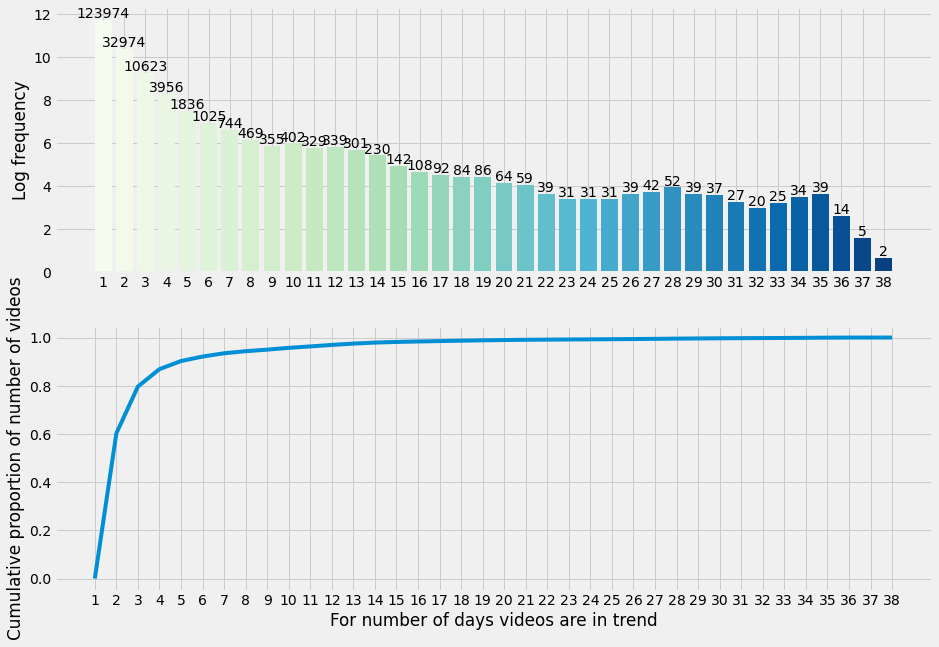

In [11]:
trending_days=collections.Counter(num_days)
days,freq=zip(*sorted(trending_days.items(),key=lambda val:val[0]))

fig,[ax1,ax2]=plt.subplots(nrows=2,ncols=1,figsize=(14,10))

cmap = plt.get_cmap('GnBu') 
colors=[cmap(i) for i in np.linspace(0, 1, len(days))]
ax1.bar(range(len(days)),np.log(freq),color=colors)
ax1.set_xticks(range(len(days)))
ax1.set_xticklabels(days)    

labels=[str(val) for val in freq]
for ind,val in enumerate(np.log(freq)):
    ax1.text(ind,val+0.1,labels[ind],ha='center')

ax1.set_xticks(range(len(days)))
ax1.set_xticklabels(days)

ax1.set_ylabel('Log frequency')

cum_arr=np.cumsum(freq)
max_val=np.max(cum_arr)
min_val=np.min(cum_arr)

ax2.plot((cum_arr-min_val)/(max_val-min_val))
ax2.set_xticks(range(len(days)))
ax2.set_xticklabels(days)
ax2.set_ylabel('Cumulative proportion of number of videos')
ax2.set_xlabel('For number of days videos are in trend');

### 2 - Trending Video Categories by Country

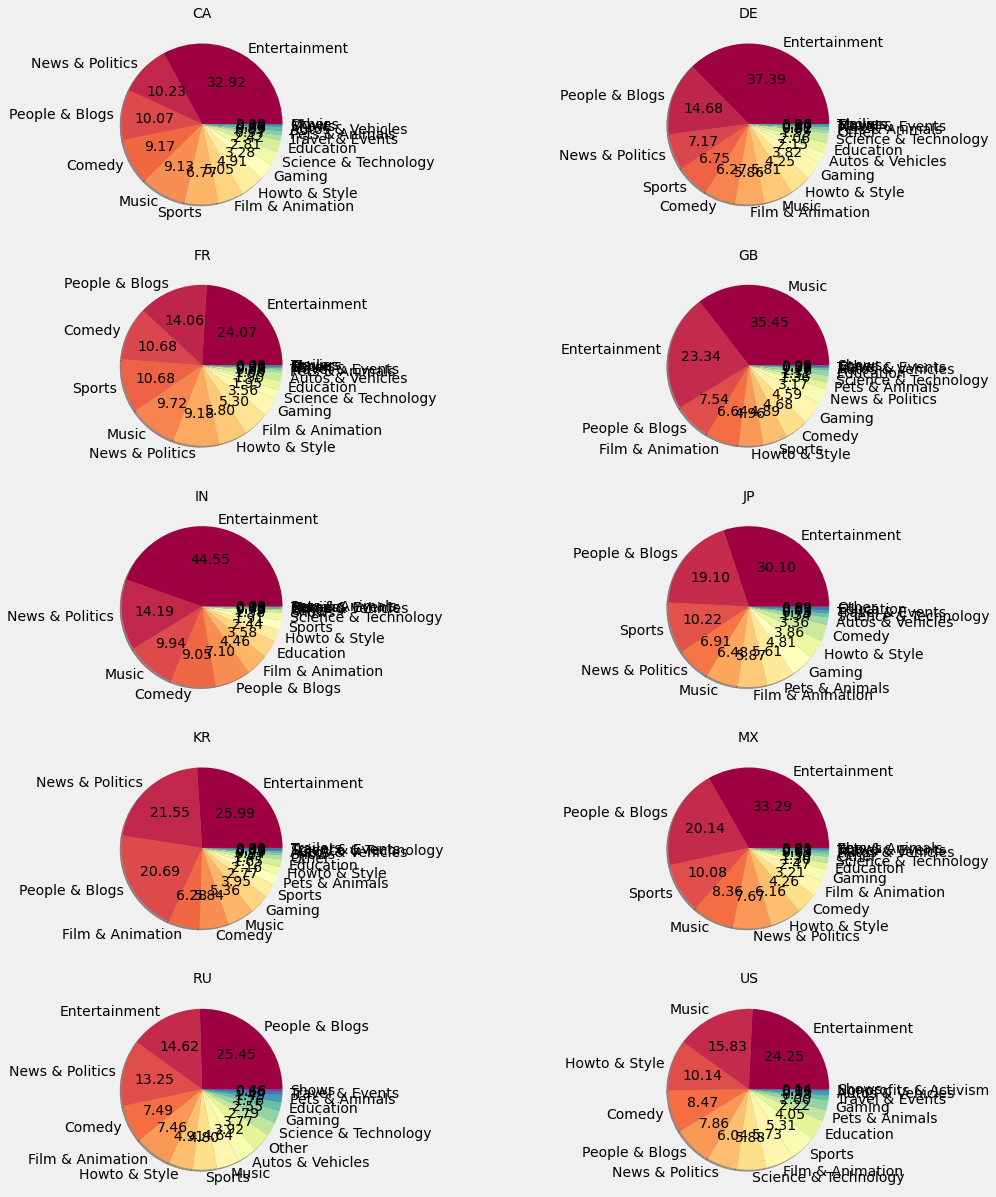

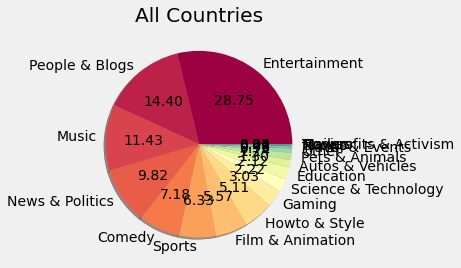

In [12]:
dataframe.category.replace({29:'Other'},inplace=True)

# 2. Count number of occurances of video category for each category
country_by_category=dataframe.groupby(by='country_code')['category'].value_counts()

# 3. Write function that will plot a pie-chart
def pie_chart(country_code,axis):
    '''Plots a pie_chart for a country_by_category series for a given country code on given axis'''
    cmap = plt.get_cmap('Spectral')
    colors=[cmap(i) for i in np.linspace(0, 1, len(country_by_category[country_code].index))]
    axis.pie(country_by_category[country_code].values,labels=country_by_category[country_code].index,autopct='%.2f',colors=colors,shadow=True)
    axis.set_title(country_code,fontsize=14);

# 4. Plot individual pie-chart for each country
fig,ax=plt.subplots(nrows=5,ncols=2,figsize=(16,20))
for c_i in range(0,len(country_codes),2):
    col=0
    ind=c_i//2
    pie_chart(country_codes[c_i],ax[ind][col])
    pie_chart(country_codes[c_i+1],ax[ind][col+1])

# 5. Plot pie-chart for all countries together
fig,ax=plt.subplots(figsize=(4,4))
cmap = plt.get_cmap('Spectral')
all_countries_prop=dataframe.category.value_counts()
colors=[cmap(i) for i in np.linspace(0, 1, len(all_countries_prop.index))]
ax.pie(all_countries_prop.values,labels=all_countries_prop.index,autopct='%.2f',colors=colors,shadow=True)
ax.set_title('All Countries');

### % of videos by countries that have comments disabled

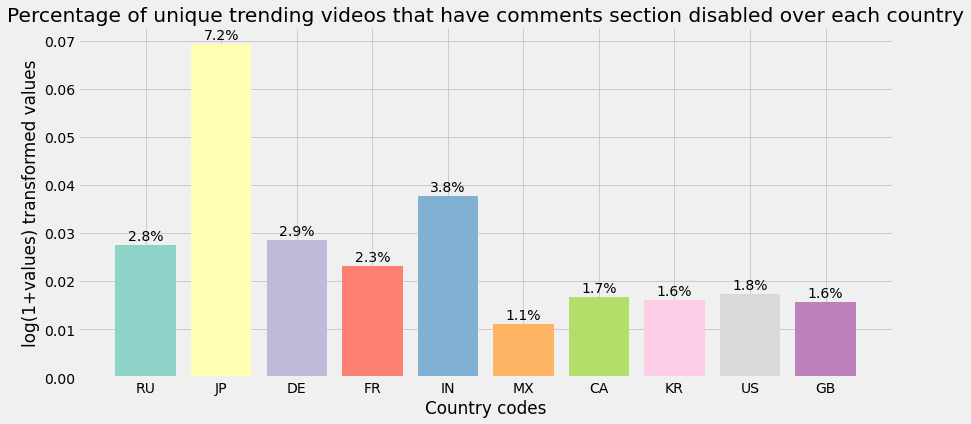

In [13]:
df_disabled=unique_video_id()
df_disabled=df_disabled[df_disabled.comments_disabled==True]
df_disabled.sort_values(by=['video_id','comments_disabled'],inplace=True)
df_disabled.drop_duplicates(subset='video_id',keep='last',inplace=True)
disabled_dict=df_disabled.country_code.value_counts().to_dict()

df_enabled=unique_video_id()
df_enabled=df_enabled[df_enabled.comments_disabled==False]
df_enabled.sort_values(by=['video_id','comments_disabled'],inplace=True)
df_enabled.drop_duplicates(subset='video_id',keep='first',inplace=True)
enabled_dict=df_enabled.country_code.value_counts().to_dict()

dis_ena_prop={}
for country in disabled_dict.keys():
    dis_ena_prop[country]=disabled_dict[country]/enabled_dict[country]

fig,ax=plt.subplots(figsize=(13,6))

cmap = plt.get_cmap('Set3')
colors=[cmap(i) for i in range(len(days))]

countries=dis_ena_prop.keys()
values=list(dis_ena_prop.values())
ax.bar(countries,np.log(np.array(list(values))+1),color=colors)
ax.set_ylabel('log(1+values) transformed values')
ax.set_xlabel('Country codes')
ax.set_title('Percentage of unique trending videos that have comments section disabled over each country')

for ind,val in enumerate(np.log(np.array(list(values))+1)):
    ax.text(ind,val+0.001,str(round(values[ind]*100,1))+'%',ha='center')

### Redo of each but with different colors

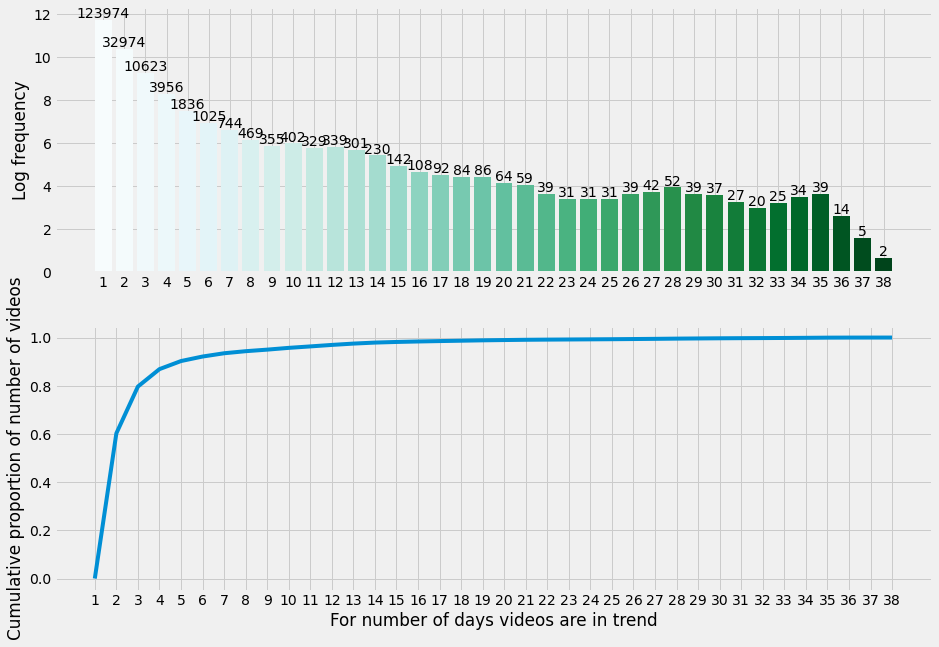

In [16]:
trending_days=collections.Counter(num_days)
days,freq=zip(*sorted(trending_days.items(),key=lambda val:val[0]))

fig,[ax1,ax2]=plt.subplots(nrows=2,ncols=1,figsize=(14,10))

cmap = plt.get_cmap('BuGn') 
colors=[cmap(i) for i in np.linspace(0, 1, len(days))]
ax1.bar(range(len(days)),np.log(freq),color=colors)
ax1.set_xticks(range(len(days)))
ax1.set_xticklabels(days)    

labels=[str(val) for val in freq]
for ind,val in enumerate(np.log(freq)):
    ax1.text(ind,val+0.1,labels[ind],ha='center')

ax1.set_xticks(range(len(days)))
ax1.set_xticklabels(days)

ax1.set_ylabel('Log frequency')

cum_arr=np.cumsum(freq)
max_val=np.max(cum_arr)
min_val=np.min(cum_arr)

ax2.plot((cum_arr-min_val)/(max_val-min_val))
ax2.set_xticks(range(len(days)))
ax2.set_xticklabels(days)
ax2.set_ylabel('Cumulative proportion of number of videos')
ax2.set_xlabel('For number of days videos are in trend');

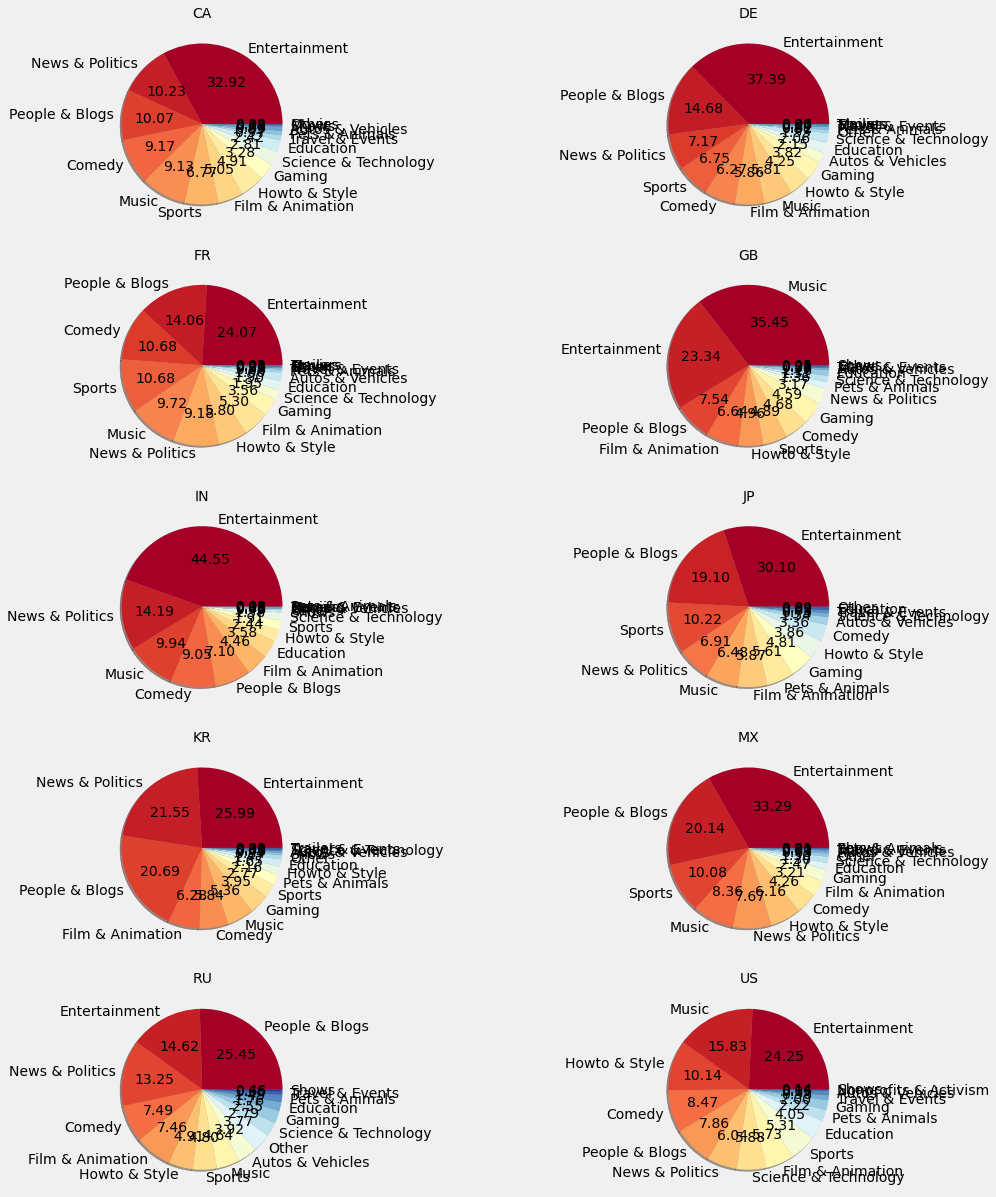

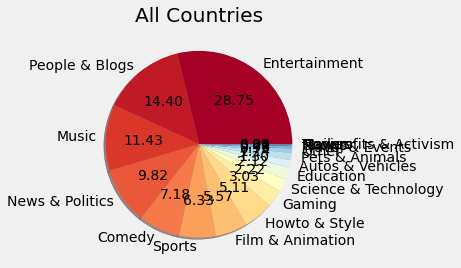

In [23]:
dataframe.category.replace({29:'Other'},inplace=True)

# 2. Count number of occurances of video category for each category
country_by_category=dataframe.groupby(by='country_code')['category'].value_counts()

# 3. Write function that will plot a pie-chart
def pie_chart(country_code,axis):
    '''Plots a pie_chart for a country_by_category series for a given country code on given axis'''
    cmap = plt.get_cmap('RdYlBu')
    colors=[cmap(i) for i in np.linspace(0, 1, len(country_by_category[country_code].index))]
    axis.pie(country_by_category[country_code].values,labels=country_by_category[country_code].index,autopct='%.2f',colors=colors,shadow=True)
    axis.set_title(country_code,fontsize=14);

# 4. Plot individual pie-chart for each country
fig,ax=plt.subplots(nrows=5,ncols=2,figsize=(16,20))
for c_i in range(0,len(country_codes),2):
    col=0
    ind=c_i//2
    pie_chart(country_codes[c_i],ax[ind][col])
    pie_chart(country_codes[c_i+1],ax[ind][col+1])

# 5. Plot pie-chart for all countries together
fig,ax=plt.subplots(figsize=(4,4))
cmap = plt.get_cmap('RdYlBu')
all_countries_prop=dataframe.category.value_counts()
colors=[cmap(i) for i in np.linspace(0, 1, len(all_countries_prop.index))]
ax.pie(all_countries_prop.values,labels=all_countries_prop.index,autopct='%.2f',colors=colors,shadow=True)
ax.set_title('All Countries');

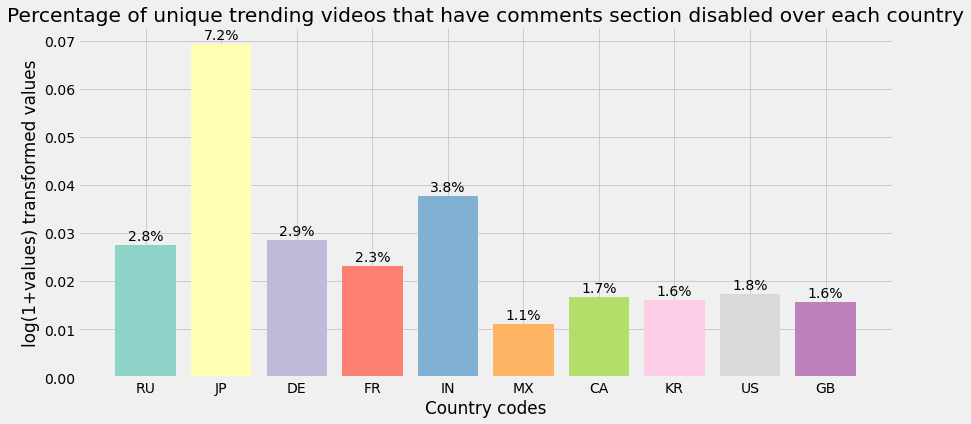

In [33]:
df_disabled=unique_video_id()
df_disabled=df_disabled[df_disabled.comments_disabled==True]
df_disabled.sort_values(by=['video_id','comments_disabled'],inplace=True)
df_disabled.drop_duplicates(subset='video_id',keep='last',inplace=True)
disabled_dict=df_disabled.country_code.value_counts().to_dict()

df_enabled=unique_video_id()
df_enabled=df_enabled[df_enabled.comments_disabled==False]
df_enabled.sort_values(by=['video_id','comments_disabled'],inplace=True)
df_enabled.drop_duplicates(subset='video_id',keep='first',inplace=True)
enabled_dict=df_enabled.country_code.value_counts().to_dict()

dis_ena_prop={}
for country in disabled_dict.keys():
    dis_ena_prop[country]=disabled_dict[country]/enabled_dict[country]

fig,ax=plt.subplots(figsize=(13,6))

cmap = plt.get_cmap('Set3')
colors=[cmap(i) for i in range(len(days))]

countries=dis_ena_prop.keys()
values=list(dis_ena_prop.values())
ax.bar(countries,np.log(np.array(list(values))+1),color=colors)
ax.set_ylabel('log(1+values) transformed values')
ax.set_xlabel('Country codes')
ax.set_title('Percentage of unique trending videos that have comments section disabled over each country')

for ind,val in enumerate(np.log(np.array(list(values))+1)):
    ax.text(ind,val+0.001,str(round(values[ind]*100,1))+'%',ha='center')